In this brief tutorial, we will go through how to implement a simple regression discontinuity design, using the functions in the `rdd` package.

In [43]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf


def optimal_bandwidth(Y, X, cut=0):
    '''
    DESCRIPTION:
        For a given outcome Y and running variable X, computes the optimal bandwidth
        h using a triangular kernel. For more information, see 
        "OPTIMAL BANDWIDTH CHOICE FOR THE REGRESSION DISCONTINUITY ESTIMATOR",
        by Imbens and Kalyanaraman, at http://www.nber.org/papers/w14726.pdf

    INPUTS:
        Two equal length pandas Series
            Y: the outcome variable
            X: the running variable
        cut: value for the threshold of the rdd (scalar) (default is 0)
    
    OUTPUTS:
        Scalar optimal bandwidth value
    '''

    assert(X.shape[0] == Y.shape[0], "X and Y are not of the same length")
    assert(np.sum(pd.isnull(X)) == 0, "NaNs are present in the running variable X")
    assert(np.sum(pd.isnull(Y)) == 0, "NaNs are present in the running variable X")


    # Normalize X
    X = X - cut

    # Step 1
    h1 = 1.84 * X.std() * (X.shape[0]**(-.2))
    Nh1neg = X[(X < 0) & (X > -h1)].shape[0]
    Nh1pos =X[(X >= 0) & (X < h1)].shape[0]
    Ybarh1neg = Y[(X < 0) & (X > -h1)].mean()
    Ybarh1pos = Y[(X >= 0) & (X < h1)].mean()
    fXc = (Nh1neg + Nh1pos) / (2 * X.shape[0] * h1)
    sig2c = (((Y[(X < 0) & (X > -h1)]-Ybarh1neg)**2).sum() +((Y[(X >= 0) & (X < h1)]-Ybarh1pos)**2).sum()) / (Nh1neg + Nh1pos)
    
    # Step 2
    medXneg = X[X<0].median()
    medXpos = X[X>=0].median()
    dat_temp = pd.DataFrame({'Y': Y,'X':X})
    dat_temp = dat_temp.loc[(dat_temp['X'] >= medXneg) & (dat_temp['X'] <= medXpos)]
    dat_temp['treat'] = 0
    dat_temp.loc[dat_temp['X'] >= 0, 'treat'] = 1
    dat_temp['X2'] = X**2
    dat_temp['X3'] = X**3
    eqn = 'Y ~ 1 + treat + X + X2 + X3'
    results = smf.ols(eqn, data=dat_temp).fit()
    m3 = 6*results.params.loc['X3']
    h2pos = 3.56 * (X[X>=0].shape[0]**(-1/7.0)) * (sig2c/(fXc * np.max([m3**2, .01]))) ** (1/7.0)
    h2neg = 3.56 * (X[X<0].shape[0]**(-1/7.0)) * (sig2c/(fXc * np.max([m3**2, .01]))) ** (1/7.0)
    Yplus = Y[(X>=0) & (X<=h2pos)]
    Xplus = X[(X>=0) & (X<=h2pos)]
    dat_temp = pd.DataFrame({'Y': Yplus,'X':Xplus})
    dat_temp['X2'] = X**2
    eqn = 'Y ~ 1 + X + X2'
    results = smf.ols(eqn, data=dat_temp).fit()
    m2pos = 2*results.params.loc['X2']
    Yneg = Y[(X<0) & (X>=-h2neg)]
    Xneg = X[(X<0) & (X>=-h2neg)]
    dat_temp = pd.DataFrame({'Y': Yneg,'X':Xneg})
    dat_temp['X2'] = X**2
    eqn = 'Y ~ 1 + X + X2'
    results = smf.ols(eqn, data=dat_temp).fit()
    m2neg = 2*results.params.loc['X2']
    
    # Step 3
    rpos = 720*sig2c / (X[(X>=0) & (X<=h2pos)].shape[0] * h2pos**4)
    rneg = 720*sig2c / (X[(X<0) & (X>=-h2neg)].shape[0] * h2neg**4)
    CK = 3.4375
    hopt = CK * (2*sig2c/(fXc * ((m2pos - m2neg)**2 + (rpos+rneg))))**.2 * Y.shape[0]**(-.2)
    
    return hopt


def truncated_data(data, xname, bandwidth=None, yname=None, cut=0):
    '''

    Drop observations from dataset that are outside 
        a given (or optimal) bandwidth

    INPUTS:
        data: data with the X and Y values (pandas DataFrame)
        xname: Name of your running variable (string)
        bandwidth: Bandwidth (scalar) (if None given, the optimal bandwidth is computed)
        yname: The name of your outcome variable (string) (only needed if no bandwidth is given)
        cut: The value of your threshold (scalar) (default is 0)

    OUTPUTS:
        pandas DataFrame with observations outside of the bandwidth dropped
    
    '''
    if bandwidth==None:
        if yname==None:
            raise NameError("You must supply either a bandwidth or the name of your outcome variable.")
        else:
            bandwidth = optimal_bandwidth(data[yname], data[xname], cut=cut)
    data_new = data.loc[np.abs(data[xname]-cut)<=bandwidth, ]
    return data_new


def rdd(input_data, xname, yname=None, cut=0, equation=None, controls=None, noconst=False, weights=1, verbose=True):
    '''
    This function implements a linear regression (ordinary or weighted least squares can be used) for 
        the estimation of regressing the outcome variable on the running variable.  A "TREATED" variable
        is created, the coefficient on which is the causal effect of being to the right of the threshold.

        The user may specify a list of controls to be added linearly, or supply their own equation.  

    INPUT:
        input_data: dataset with outcome and running variables (and potentially controls) (pandas DataFrame)
        xname: name of running variable (string)
        yname: name of outcome variable (string) (default is None - not needed if you include your own equation)
        cut: location of threshold in xname (scalar) (default is 0)
        equation: Estimation equation as a string (see Statsmodels formula syntax for more info)
        controls: List of controls to include in the estimation (list of strings) (not needed if you include your own equation)
        noconst: If True, model does not estimate an intercept (bool) (default is false)
        weights: Weights for weighted least squares (numpy array) (default is equal weights, ie OLS)

    OUTPUT:
        Statsmodels object

    '''
    if yname==None and equation==None:
        raise NameError("You must supply either a outcome variable name or an equation to estimate.")
    if 'TREATED' in input_data.columns:
        raise NameError("TREATED is a reserved column name.  Please change the name.")
    data = input_data.copy() # To avoid SettingWithCopy warnings
    data['TREATED'] = np.where(data[xname] >= cut, 1, 0)
    if equation==None:
        equation = yname + ' ~ TREATED + ' + xname
        if controls != None:
            equation_controls = ' + '.join(controls)
            equation += ' + ' + equation_controls
    if noconst==True:
        equation += ' -1'
    if verbose==True:
        print('Estimation Equation:\t', equation)
    rdd_model = smf.wls(equation, data=data, weights=weights)
    return rdd_model


def bin_data(data, yname, xname, bins=50, agg_fn=np.mean):
    '''
    When datasets are so large that traditional RDD scatter plots are difficult to read, 
        this will group observations by their X values into a set number of bins and compute
        the mean outcome value in that bin.  

    INPUT:
        data: dataset (pandas DataFrame)
        yname: Name of outcome variable (string)
        xname: Name of running variable (string)
        bins: Desired number of bins to group data by (integer) (default is 50)

    OUTPUT:
        A pandas DataFrame that has a row for each bin with columns:
            yname: The average value of the outcome variable in that bin
            xname: the midpoint value of the running variable in that bin
            n_obs: The number of observations in this bin
            
    '''
    hist, edges = np.histogram(data[xname], bins=bins)
    bin_midpoint = np.zeros(edges.shape[0]-1)
    binned_df = pd.DataFrame(np.zeros((edges.shape[0]-1, 1)))
    for i in range(edges.shape[0]-1):
        bin_midpoint[i] = (edges[i] + edges[i+1]) / 2
        if i < edges.shape[0]-2:
            dat_temp = data.loc[(data[xname] >= edges[i]) & (
                data[xname] < edges[i+1]), :]
            binned_df.loc[binned_df.index[i], yname] = agg_fn(dat_temp[yname])
            binned_df.loc[binned_df.index[i], xname] = bin_midpoint[i]
            binned_df.loc[binned_df.index[i], 'n_obs'] = dat_temp.shape[0]
        else:
            dat_temp = data.loc[(data[xname] >= edges[i]) & (
                data[xname] <= edges[i+1]), :]
            binned_df.loc[binned_df.index[i], yname] = agg_fn(dat_temp[yname])
            binned_df.loc[binned_df.index[i], xname] = bin_midpoint[i]
            binned_df.loc[binned_df.index[i], 'n_obs'] = dat_temp.shape[0]
    return binned_df

<>:24: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:25: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:26: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:24: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:25: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:26: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:24: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:25: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:26: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-43-e39786319a78>:24: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(X.shape[0] == Y.shape[0], "X and Y are not of the same length")
<ipython-input-43-e39786319a78>:25: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(np.sum(pd.isnull(X)) == 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from rdd import rdd

## Variables:

1. Dropput index : Higher the value lower the dropout.
2. family_indx : Higher the value higher is the need to acquire financial aid
3. w1 : Some exogenous factor that impacts dropout
4. w1 : some other exogenous factor that impacts dropout

## Idea:

* To measure the impact of college dropout in students with respect to the provision of financial aid.

In [36]:
np.random.seed(42)

In [37]:
N = 10000
x = np.random.normal(1, 1, N)
epsilon = np.random.normal(0, 1, N)
threshold = 1
treatment = np.where(x >= threshold, 1, 0)
w1 = np.random.normal(0, 1, N)
w2 = np.random.normal(0, 4, N)
y = .5 * treatment + 2 * x - .2 * w1 + 1 + epsilon

data = pd.DataFrame({'dropout_indx':y, 'family_indx': x, 'w1':w1, 'w2':w2})
#data['treatment'] = treatment
data.head()

,dropout_indx,family_indx,w1,w2
0,3.745276,1.496714,0.348286,-7.922288
1,2.361307,0.861736,0.283324,-4.219943
2,4.385300,1.647689,-0.936520,-2.348114
3,6.540561,2.523030,0.579584,0.598676
4,4.026888,0.765847,-1.490083,4.096649


In [38]:
data.shape

(10000, 4)

# Restrict Data

When running our RDD, we first want to choose a bandwidth that we will use to restrict our dataset to only analyze observations that are very close to the threshold.  We can pick whatever bandwidth we like, or we can select the optimal bandwidth.

We do this by giving `optimal_bandwidth()` our outcome variable, the running variable, and the threshold in the running variable.

In [39]:
bandwidth_opt = optimal_bandwidth(data['dropout_indx'], data['family_indx'], cut=threshold)
print("Optimal bandwidth:", bandwidth_opt)

Optimal bandwidth: 0.7448859965965804


Now let's restrict the dataset to be only observations within this bandwidth of the threshold. 

(Note: `truncated_data()` can also call `optimal_bandwidth()`, which saves you a step)

In [40]:
data_rdd = truncated_data(data, 'family_indx', bandwidth_opt, cut=threshold)

# Check for the Presence of a Discontinuity

Before we move to estimation, let's see if graphically it even looks like there is a discontinuous change in the outcome at the threshold.  We use a regular scatter plot.

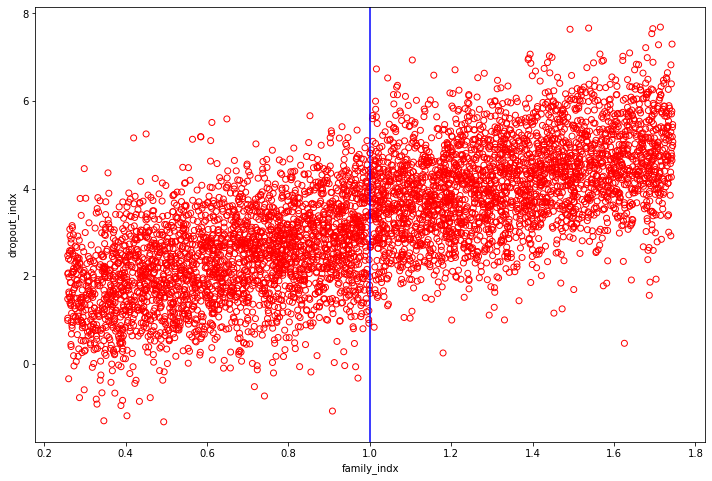

In [41]:
plt.figure(figsize=(12, 8))
plt.scatter(data_rdd['family_indx'], data_rdd['dropout_indx'], facecolors='none', edgecolors='r')
plt.xlabel('family_indx')
plt.ylabel('dropout_indx')
plt.axvline(x=threshold, color='b')
plt.show()
plt.close()

As you can see, it's really hard to tell what's going on at the threshold - it's far to noisy.  So what we'll do is put the data into bins based on the running variable, get the average value of the outcome variable in each bin, then plot the result.  This will allow us to parse through the noise.

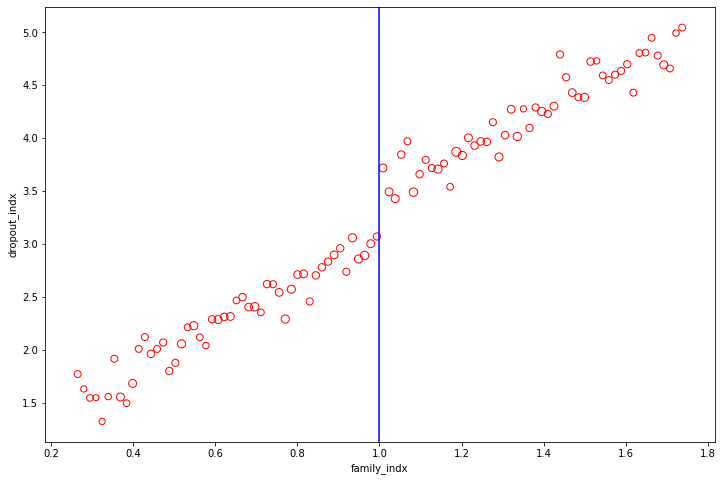

In [45]:
data_binned = bin_data(data_rdd, 'dropout_indx', 'family_indx', 100)
plt.figure(figsize=(12, 8))
plt.scatter(data_binned['family_indx'], data_binned['dropout_indx'],
    s = data_binned['n_obs'], facecolors='none', edgecolors='r')
plt.axvline(x=threshold, color='b')
plt.xlabel('family_indx')
plt.ylabel('dropout_indx')
plt.show()
plt.close()

That's better - it's much easier to see discontinuity now. When we run our estimation, it should be easy to detect this.  If we didn't see any change in the plot, but did find a treatment effect in our estimation (or vice versa), we might be worried.

Why do we weight by the number of observations in each bin?  The number of observations is not equal across bins, and this can help inform the results we get from our estimation in the next step.

# Estimation

Now the fun part.  All we have to do is estimate a simple linear regression of the outcome variable on a dummy variable for whether the observations lies to the right or left of the variable (which we'll call `TREATED`), and the running variable.  We could do this ourselves, but we can also run `rdd()`.  The output will be a Statsmodels linear regression object, which we can then fit and display results for.

(Note: While weighted least squares is used, the default weights are 1, resulting in OLS by default.)

In [48]:
model = rdd(data_rdd, 'family_indx', 'dropout_indx', cut=threshold)
print(model.fit().summary())

Estimation Equation:	 dropout_indx ~ TREATED + family_indx
                            WLS Regression Results                            
Dep. Variable:           dropout_indx   R-squared:                       0.508
Model:                            WLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     2811.
Date:                Thu, 29 Dec 2022   Prob (F-statistic):               0.00
Time:                        13:50:27   Log-Likelihood:                -7794.0
No. Observations:                5442   AIC:                         1.559e+04
Df Residuals:                    5439   BIC:                         1.561e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

It looks pretty good! We're getting a treatment effect that is pretty close to the actual treatment effect (even though we've omitted a variable).

We can also add controls, change the covariance structure, specify our own equation, or run weighted least squares.

In [49]:
model = rdd(data_rdd, 'family_indx', 'dropout_indx', cut=threshold, controls=['w1', 'w2'])
print(model.fit(cov_type='hc1').summary())

Estimation Equation:	 dropout_indx ~ TREATED + family_indx + w1 + w2
                            WLS Regression Results                            
Dep. Variable:           dropout_indx   R-squared:                       0.523
Model:                            WLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     1520.
Date:                Thu, 29 Dec 2022   Prob (F-statistic):               0.00
Time:                        13:50:39   Log-Likelihood:                -7709.9
No. Observations:                5442   AIC:                         1.543e+04
Df Residuals:                    5437   BIC:                         1.546e+04
Df Model:                           4                                         
Covariance Type:                  hc1                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

In [51]:
model = rdd(data_rdd, 'family_indx', cut=threshold, equation='dropout_indx ~ TREATED + family_indx + w1*w2')
print(model.fit().summary())

Estimation Equation:	 dropout_indx ~ TREATED + family_indx + w1*w2
                            WLS Regression Results                            
Dep. Variable:           dropout_indx   R-squared:                       0.523
Model:                            WLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     1194.
Date:                Thu, 29 Dec 2022   Prob (F-statistic):               0.00
Time:                        13:51:00   Log-Likelihood:                -7709.6
No. Observations:                5442   AIC:                         1.543e+04
Df Residuals:                    5436   BIC:                         1.547e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

# Validation: Placebo Tests

How can we check to see if our results are robust?  One method is to repeat the analysis, using a fake threshold.  This placebo test should result in a null treatment effect -- since the threshold is fake, nothing is inherently different for observations on either side.  If we do still see a statistially significant coefficient on `TREATED`, that may be cause for alarm.

Let's put a fake threshold at 0, and test for the causal effect there.

In [53]:
data_placebo = truncated_data(data, 'family_indx', yname='dropout_indx', cut=0)

In [54]:
model = rdd(data_placebo, 'family_indx', 'dropout_indx', cut=0, controls=['w1'])
print(model.fit().summary())

Estimation Equation:	 dropout_indx ~ TREATED + family_indx + w1
                            WLS Regression Results                            
Dep. Variable:           dropout_indx   R-squared:                       0.375
Model:                            WLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     660.8
Date:                Thu, 29 Dec 2022   Prob (F-statistic):               0.00
Time:                        13:51:44   Log-Likelihood:                -4633.4
No. Observations:                3310   AIC:                             9275.
Df Residuals:                    3306   BIC:                             9299.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

There's no statistical effect!  Excellent.